https://blog.floydhub.com/colorizing-b-w-photos-with-neural-networks/

In [1]:
import os
import glob
import cv2
import time
import random
import webbrowser
import numpy as np
import pandas as pd
from numpy import reshape
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import savefig

from cv2 import imread, imwrite
import tensorflow as tf
#from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Flatten, Reshape
from tensorflow.keras.layers import Input, Activation, Dense, Dropout, Flatten, InputLayer, BatchNormalization, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

from skimage import color
from skimage.io import imsave
from skimage.transform import resize
from skimage.io import imsave, imread, imshow
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function       #repasar funcion y explicar en exposicion

#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

In [2]:
# Get images
X = []
for filename in os.listdir('color_images256/'):
    X.append(img_to_array(load_img('color_images256/'+filename)))
X = np.array(X, dtype=float)

# Set up training and test data
split = int(0.9*len(X))
Xtrain = X[:split]
Xtrain = 1.0/255*X

In [3]:
#Encoder
encoder_input = Input(shape=(256, 256, 1,))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)


model = Model(inputs=encoder_input, outputs=decoder_output)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 256)       590080    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 512)       118016

In [4]:
TensorBoard(log_dir='/callback')
model.compile(optimizer='adam', loss='mse')

In [6]:
# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

# Generate training data
batch_size = 20
def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)

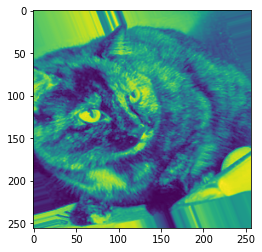

In [7]:
t = image_a_b_gen(3)
for x, y in t:
    plt.imshow(x[0])
    break


In [12]:
plt.imshow(y[0])

TypeError: Invalid shape (256, 256, 2) for image data

In [13]:
# Train model
model.fit(image_a_b_gen(batch_size), steps_per_epoch=10, epochs=10)
# Test images
Xtest = rgb2lab(1.0/255*X[split:])[:,:,:,0]
Xtest = Xtest.reshape(Xtest.shape+(1,))
Ytest = rgb2lab(1.0/255*X[split:])[:,:,:,1:]
Ytest = Ytest / 128
print(model.evaluate(Xtest, Ytest, batch_size=batch_size))

In [14]:
color_me = []
for filename in os.listdir('test256/'):
        color_me.append(img_to_array(load_img('test256/'+filename)))
color_me = np.array(color_me, dtype=float)
color_me = rgb2lab(1.0/255*color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))

In [23]:
# Test model
output = model.predict(color_me)
output = output * 128

In [22]:
# Output colorizations
for i in range(len(output2)):
        cur = np.zeros((256, 256, 3))
        cur[:,:,0] = color_me[i][:,:,0]
        cur[:,:,1:] = output[i]
        imsave("result3/uint8_"+str(i)+".png", lab2rgb(cur))

ValueError: could not broadcast input array from shape (256,256,3) into shape (256,256,2)

In [20]:
# Test model
output2 = model.predict(color_me)
output2 = output *128
output2 = output.astype(np.uint8)

In [21]:
for i in range(len(output2)):
        cur = np.zeros((256, 256, 3))
        cur[:,:,0] = color_me[i][:,:,0]
        cur[:,:,1:] = output[i]
        imsave("result3/uint8_"+str(i)+".png", lab2rgb(cur))

ValueError: could not broadcast input array from shape (256,256,3) into shape (256,256,2)

In [14]:
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)

model.save('model.h5')

in_hsv_h = color.convert_colorspace(output, 'RGB', 'HSV')
in_hsv_s = in_hsv_h.copy()
in_hsv_v = in_hsv_h.copy()

for i in range(newImage.shape[0]):
    in_hsv_h[i,:,0] = np.sort(in_hsv_h[i,:,0])
    in_hsv_s[i,:,1] = np.sort(in_hsv_s[i,:,1])
    in_hsv_v[i,:,2] = np.sort(in_hsv_v[i,:,2])

imsave('testing-sorted-hue.png', (color.convert_colorspace(in_hsv_h, 'HSV', 'RGB')*255).astype(np.uint8))
imsave('testing-sorted-saturation.png', (color.convert_colorspace(in_hsv_s, 'HSV', 'RGB')*255).astype(np.uint8))